<a href="https://colab.research.google.com/github/ccg-esb/EvK/blob/main/py_pOXA48_SI3_multistrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
import operator
import numpy as np
import pandas as pd
import sys
import colorcet as cc
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle

In [26]:
from google.colab import drive
drive.mount('/content/drive')

root='/content/drive/MyDrive/SYNC_Projects/pOXA48/2023/code/py-files/'
os.chdir(root)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## __SI:__ Antimicrobial resistance level and conjugation permissiveness shape plasmid distribution in clinical enterobacteria

### 3. Modeling plasmid dynamics in multistrain communities

In this notebook, we extend the plasmid population dynamics model to consider that ...

In [27]:
sys.path.insert(0, 'src/')
from pOXA48_S1 import *
from pOXA48_S2 import *
from pOXA48_S3 import *

%run src/pOXA48_parameters
print_expe_params(expe_params)


Experimental Parameters:
------------------------------------------------
	Initial bacterial density (B0): 1000000.0
	Maximum drug concentration (A_max): 131072
	Antibiotic degradation rates (alphas): [1.e-10 1.e-12]
	Length of experiment (T): 24
	Initial resource concentration (S0): 1.0
	Resource decay rate (d): 0.1
	Extinction threshold: 1.0
------------------------------------------------


<Figure size 640x480 with 0 Axes>


For each strain $i$, we denote the densities of plasmid-bearing and plasmid-free subpopulations as $B_{pi}$ and $B_i$, respectively. The entire bacterial community at a given time $t$ can be symbolically expressed as a vector: $\mathbf{B}(t) = (B_{p1}(t), B_{p2}(t), ..., B_{pM}(t), B_1(t), B_2(t), ..., B_M(t))$.

As each cell consumes the limiting resource at rates defined by their individual growth kinetic parameters, the rate of resource $R$ change over time is dictated by:
$$
\frac{{dR}}{{dt}} = -\sum_{i=1}^{M} (u_{pi}(R(t))B_{pi}(t) + u_i(R(t))B_i(t)) - dR.
$$

We postulate that antibiotic molecules are deactivated at a rate proportional to the total bacterial population and the environmental drug concentration. This is mathematically represented as:
$$
\frac{{dA}}{{dt}} = -\sum_{i=1}^{M} (B_{pi}(t) + B_i(t)) - dA.
$$

Given that plasmid conjugation is contingent on the recipient cell, the strain $i$'s receptiveness towards the pOXA-48 plasmid is defined by $i$. Therefore, the plasmid-bearing subpopulation's growth of strain $i$ hinges on the collective contribution of all plasmid-bearing populations:
$$\frac{{dB_{pi}}}{{dt}} = p_iu_{pi}(R)(1 - p_iA)B_{pi} + \sum_{j=1}^{M} B_{pj} - dB_{pi}.$$

Likewise, the population dynamics of the plasmid-free strain $i$ can be captured as:
$$\frac{{dB_i}}{{dt}} = u(R)(1 - A)B_i + p_iu_{pi}(R)B_{pi} - \sum_{j=1}^{M} B_{pj} - dB_i.$$

The initial conditions for the simulations stem from a competition experiment where all strains in the community, both plasmid-bearing and plasmid-free, are introduced at equivalent initial densities at time $t=0$.

In [28]:

def dB_conj(B_WT, B_TC, conj_exponent):
    if np.isnan(conj_exponent): # Below detectable limits
        conj_rate = 0
    else:
        conj_rate = 10**conj_exponent
    ret = 0
    if np.size(B_TC) == 1:
        ret = conj_rate * B_WT * B_TC  # Changed Bdonor to B_TC because in this case B_TC is a float
    else:
        for Bdonor in B_TC:
            ret += conj_rate * B_WT * Bdonor
    return ret

def fMultistrain(t, y, params):
    S = y[0]
    A = y[1]
    num_strains = int(len(params['strain']) / 2)
    B_TC = y[2:num_strains + 2]
    B_WT = y[num_strains + 2:]

    uStot = 0
    dB = np.zeros(2 * num_strains)

    # For plasmid-bearing (TC)
    for i in range(num_strains):

        uSi_TC = uS(S, params['VKm'].iloc[i])
        uStot += uSi_TC * B_TC[i]

        dB_TC_growth = params['rho'].iloc[i] * uSi_TC * B_TC[i]
        dB_TC_seg = params['rho'].iloc[i] * uSi_TC * B_TC[i] * params['seg_rate'].iloc[i]

        db_MIC_TC = params['kappa'].iloc[i]
        dB_TC_kill = dB_kill(A, B_TC[i], db_MIC_TC, params.attrs['A_max'])

        conj_permissiveness=params['conj_rate'].iloc[i+num_strains] #permissiveness of WT
        dB_TC_conj = dB_conj(B_WT[i], B_TC, conj_permissiveness)


        dB[i] = dB_TC_growth + dB_TC_conj - dB_TC_seg - dB_TC_kill

    # For plasmid-free (WT)
    for i in range(num_strains, 2*num_strains):

        uSi_WT = uS(S, params['VKm'].iloc[i])
        uStot += uSi_WT * B_WT[i-num_strains]

        dB_WT_growth = params['rho'].iloc[i] * uSi_WT * B_WT[i-num_strains]

        db_MIC_WT = params['kappa'].iloc[i]
        dB_WT_kill = dB_kill(A, B_WT[i-num_strains], db_MIC_WT, params.attrs['A_max'])

        uSi_TC = uS(S, params['VKm'].iloc[i-num_strains])
        dB_WT_seg= params['rho'].iloc[i - num_strains] * uSi_TC * B_TC[i - num_strains] * params['seg_rate'].iloc[i-num_strains]

        conj_permissiveness=params['conj_rate'].iloc[i] #permissiveness of WT
        dB_WT_conj = dB_conj(B_WT[i-num_strains], B_TC, conj_permissiveness)

        dB[i] = dB_WT_growth - dB_WT_conj - dB_WT_kill + dB_WT_seg

    dS =  - uStot
    dA = -A * (params.attrs['alphas'][0] * np.sum(B_TC) + params.attrs['alphas'][1] * np.sum(B_WT))

    return np.concatenate(([dS], [dA], dB))


In [29]:
def simulate_multistrain(this_params, istrains, y0):
    strains_params=get_selected_strains_params(this_params, istrains)

    num_strains = int((len(y0)-2) / 2)
    # Set initial conditions
    S0 = this_params.attrs['S0']
    B0 = this_params.attrs['B0']

    t_span = [0, this_params.attrs['T']]

    # Solve the ODE
    sol = solve_ivp(fMultistrain, t_span, y0, args=(strains_params,), method='Radau')

    # Extract the time points and solution vectors
    times = sol.t
    ys = sol.y

    return times, ys, strains_params


### Model parameters

In [30]:

num_days=10

powers = np.arange(-4.0, 20.0, 0.1)  # array of powers of two exponents
Amax_values=np.power(2.0, powers)  # calculate 2 raised to each exponent

type_experiment='invasion'

In [31]:

figPathN="%sN%s/"%(figPath, num_days)
if not os.path.exists(figPathN):
  os.makedirs(figPathN)


In [32]:
model_params = import_model_params("%smodel_params.csv"%(dataPath), expe_params)

display_model_params(model_params, strains_subset)

╒════╤══════════╤══════════╤══════════╤════════╤══════════╤═══════╤═════════════╤══════════╤═════════════╤════════════╤═════════════╕
│    │ name     │ strain   │ specie   │ type   │      PCN │   MIC │   conj_rate │      VKm │         rho │   seg_rate │       kappa │
╞════╪══════════╪══════════╪══════════╪════════╪══════════╪═══════╪═════════════╪══════════╪═════════════╪════════════╪═════════════╡
│  2 │ PF_EC02  │ C002     │ E        │ TC     │   1.3351 │  8192 │    nan      │ 7.6e-10  │ 5.50386e+08 │      0.002 │ 0.0625      │
├────┼──────────┼──────────┼──────────┼────────┼──────────┼───────┼─────────────┼──────────┼─────────────┼────────────┼─────────────┤
│  3 │ PF_EC03  │ C006     │ E        │ TC     │   2.2371 │  6144 │    nan      │ 7.6e-10  │ 8.90018e+08 │      0.002 │ 0.0625      │
├────┼──────────┼──────────┼──────────┼────────┼──────────┼───────┼─────────────┼──────────┼─────────────┼────────────┼─────────────┤
│  7 │ PF_EC07  │ C022     │ E        │ TC     │   1.0054 │  6

In [33]:
def get_selected_strains_params(model_params, istrains):
    num_strains = int(len(model_params) / 2)

    indices_tc = model_params.loc[(model_params.index.isin(istrains)) & (model_params['type'] == 'TC')].index
    indices_wt = indices_tc + num_strains

    output = pd.DataFrame()

    for key in model_params.columns:
        if key == 'type':
            output[key] = ['TC'] * len(indices_tc) + ['WT'] * len(indices_wt)
        else:
            output[key] = model_params.loc[indices_tc, key].tolist() + model_params.loc[indices_wt, key].tolist()

    output.attrs = model_params.attrs
    return output


## Serial dilution protocol

Serial dilution experiments are a key methodology in microbiology, enabling the study of microbial growth, survival, and behavior under varying environmental conditions. These experiments are cyclical, consisting of the incubation of microbial cultures, followed by their dilution, and then a subsequent growth phase. To model this process, where multiple bacterial strains compete for space and a single limiting resource, we use numerical simulations. In this simulation, $S$ represents the growth medium that supports bacterial proliferation, while $E$ designates an ordered series of antibiotic concentrations applied sequentially on each day of the experiment.

In the initial conditions of the experiment, a bacterial population is introduced into a medium abundant in substrate and exposed to an initial antibiotic concentration 'A'. To simulate a scenario of plasmid invasion, it is assumed that all bacteria are initially devoid of plasmids, with the exception of a single strain carrying a plasmid. Therefore, we denote the substrate concentration 'S' is initialized to 'S0', the initial antibiotic concentration is set to 'A', the plasmid-carrying bacteria (type-TC) for each strain are initialized to '0', and the plasmid-free bacteria (type-WT) for each strain are evenly distributed to sum to 'B0'. The plasmid-carrying bacteria of the first strain is then set to 'B0', signifying the start of the plasmid invasion.

From the second day onward, the system undergoes a daily 'serial dilution' simulation. This operation involves diluting the bacterial population from the previous day by a factor 'd'. Subsequently, the system is replenished with fresh substrate up to 'S0'. Post dilution, the bacteria are subjected to growth in the presence of fresh media and a new antibiotic concentration.

This iterative sequence of growth, dilution, and regrowth extends over a predetermined number of days. The simulation tracks the progression of bacterial population dynamics, documenting the changes in the densities of various bacterial strains over time. The introduction of an antibiotic exerts a selective pressure that may benefit resistant strains. This setup offers valuable insights into the dynamics between bacterial growth, plasmid transfer, and antibiotic resistance.

In [34]:
def simulateTransfers_multistrain(model_params, istrains, E, type_experiment='invasion', verbose=False):
    times_list = []
    ys_list = []
    strains_params_list = []
    num_strains = len(istrains)

    # Set initial conditions
    S0 = model_params.attrs['S0']
    B0 = model_params.attrs['B0']

    #print("E=%s"%E)
    for day in range(len(E)):
        A = E[day]

        if day == 0:
            #Competition experiment
            if type_experiment=='competition':
                yi = np.concatenate(([S0], [A], B0 * np.ones(2 * num_strains) / (num_strains * 2)))

            else : #invasion experiment
                istrains_TC0 = np.zeros(num_strains)
                istrains_WT0 = B0 * np.ones(num_strains) / num_strains
                yi = np.concatenate(([S0], [A], istrains_TC0, istrains_WT0))
                yi[2]=B0*1e-6

            # Simulation for the first day
            times, ys, strains_params = simulate_multistrain(model_params, istrains, yi)

        else:
            yi = ys[:, -1] * model_params.attrs['d']  # Serial dilution
            yi[0] = model_params.attrs['S0']  # Replenish media
            # Simulations for subsequent days
            times, ys, strains_params = simulate_multistrain(model_params, istrains, yi)

        times_list.append(times)
        ys_list.append(ys)
        strains_params_list.append(strains_params)

    return times_list, ys_list, strains_params_list


In [35]:


def get_species_from_istrains(model_params, istrains):
    species = []

    for istrain in istrains:
        # Find the corresponding type in model_params and append it to the list
        this_species = model_params.loc[istrain, 'specie']
        species.append(this_species)

    # Return the list of types
    return species

def analyze_simulation(model_params, this_istrains, final_ys):

    B = np.array(final_ys)
    B=B[:,2:]
    num_days = B.shape[0]
    num_strains = B.shape[1] // 2


    species=get_species_from_istrains(model_params, this_istrains)

    # Iterate over strains and add their populations to the relevant counters
    Btot=np.zeros(num_days)
    BpE=np.zeros(num_days)
    BpK=np.zeros(num_days)
    BfE=np.zeros(num_days)
    BfK=np.zeros(num_days)
    freqpE=np.zeros(num_days)
    freqpK=np.zeros(num_days)
    for day in range(num_days):

      #print("B[",day,"]=",B[day,:])

      for i in range(num_strains):
        if species[i] == 'E':
            BpE[day] += B[day, i]
            BfE[day] += B[day, i + num_strains]
        elif species[i] == 'K':
            BpK[day] += B[day, i]
            BfK[day] += B[day, i + num_strains]

        Btot[day]+=B[day, i + num_strains]+B[day, i]

      # Compute frequencies for E and K strains separately
      if Btot[day] > 0:
          freqpE[day] = BpE[day] / Btot[day]
          freqpK[day] = BpK[day] / Btot[day]
      else:
          freqpE[day] = np.nan
          freqpK[day] = np.nan

    return Btot, BpE, BpK, BfE, BfK, freqpE, freqpK


def load_simulation_results(filename):
    with open(filename, "rb") as f:
        results = pickle.load(f)
    return results["istrains"], results["Es"],  results["Btot"], results["BpEs"], results["BpKs"], results["BfEs"], results["BfKs"], results["freqpEs"], results["freqpKs"], results["ts"], results["ys"], results["params"]

def save_simulation_results(filename, istrains, Es, Btot, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params_list):

    results = {
        "istrains": istrains,
        "Es": Es,
        "Btot": Btot,
        "BpEs": BpEs,
        "BpKs": BpKs,
        "BfEs": BfEs,
        "BfKs": BfKs,
        "freqpEs": freqpEs,
        "freqpKs": freqpKs,
        "ts":ts,
        "ys":ys,
        "params":params_list,
    }
    with open(filename, "wb") as f:
        pickle.dump(results, f)



def simulate_environment_multistrain(model_params, istrains, E, type_experiment):
    print('.', end="", flush=True)

    # Simulate transfers
    times_list, ys_list, strains_params_list = simulateTransfers_multistrain(model_params, istrains, E, type_experiment)

    # Get final points
    final_times, final_ys = get_final_points(times_list, ys_list)

    # Analyze simulation results
    Btot, BpE, BpK, BfE, BfK, freqpE, freqpK  = analyze_simulation(model_params, istrains, final_ys)

    return Btot, BpE, BpK, BfE, BfK, freqpE, freqpK, times_list, ys_list, strains_params_list



def simulate_environments_multistrain(model_params, istrains, Es, type_experiment):
    freqpEs = []
    freqpKs = []
    BpEs=[]
    BpKs=[]
    BfEs=[]
    BfKs=[]
    Btots=[]
    ts=[]
    ys=[]
    params=[]
    for E in Es:
        #print("E=%s"%E)
        Btot, BpE, BpK, BfE, BfK, freqpE, freqpK, times_list, ys_list, params_list = simulate_environment_multistrain(model_params, istrains, E, type_experiment)
        freqpEs.append(freqpE)
        freqpKs.append(freqpK)
        BfEs.append(BfE)
        BfKs.append(BfK)
        BpEs.append(BpE)
        BpKs.append(BpK)
        Btots.append(Btot)
        ts.append(times_list)
        ys.append(ys_list)
        params.append(params_list)

    return Btots, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params



In [36]:


def plotTransfers(istrains, t_list, ys_list, strains_params_list,  save_path=''):
    num_strains = int(len(strains_params_list[0]['strain']) / 2)
    num_days = len(t_list)

    plt.figure(figsize=(8, 3))
    for day in range(len(t_list)):
        t = t_list[day] + day * model_params.attrs['T']  # Add 'day' to each time point
        ys = ys_list[day]
        strains_params = strains_params_list[day]

        S = ys[0]
        B_TC = ys[2:num_strains + 2]
        B_WT = ys[num_strains + 2:]

        for i in range(len(B_WT)):
            if day == 0:  # Display legend only for the first iteration
                plt.plot(t, B_WT[i], ':', color=cmap_strains[istrains[i]]) #, label=f'{codes[i]}'
            else:
                plt.plot(t, B_WT[i], ':', color=cmap_strains[istrains[i]])

        for i in range(len(B_TC)):
            if day == 0:  # Display legend only for the first iteration
                plt.plot(t, B_TC[i], '-', color=cmap_strains[istrains[i]], label=f'{strain_names[istrains[i]]}') #, label=f'{codes[i]} (TC)'
            else:
                plt.plot(t, B_TC[i], '-', color=cmap_strains[istrains[i]], label=f'{strain_names[istrains[i]]}')


        #if np.any(np.array(B_WT) > 0.0) or np.any(np.array(B_TC) > 0.0):
        #  plt.yscale('log', base=10)

    plt.xlim([0, num_days*model_params.attrs['T']])
    plt.xlabel('Time (hours)', fontsize=16)
    plt.ylabel('Density (cells/ml)', fontsize=16)
    #plt.ylim([1e-2, 1.1e9])
    #plt.legend()


    ax = plt.gca()  # Get current Axes instance
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)


    if save_path:
      plt.savefig(save_path)
      print("Exporting %s"%save_path)

    plt.show()


In [37]:

def get_final_points(times_list, ys_list):
    final_times = []
    final_ys = []

    for day in range(len(times_list)):
        t = times_list[day]
        ys = ys_list[day]
        final_time = t[-1]  # Get the last time point
        final_y = ys[:, -1]  # Get the last solution vector
        final_times.append(final_time)
        final_ys.append(final_y)

    return final_times, final_ys
def plotTransfersFinalPoint(istrains, t_list, ys_list, strains_params_list, save_path=''):

    num_strains = int(len(strains_params_list[0]['strain']) / 2)
    num_days = len(t_list)

    plt.figure(figsize=(8, 3))
    t = np.arange(num_days)

    for i in range(num_strains):
        B_WT_day = []
        B_TC_day = []
        for day in range(num_days):
            ys = ys_list[day]
            strains_params = strains_params_list[day]

            B_TC = ys[2:num_strains + 2]
            B_WT = ys[num_strains + 2:]

            #if day==0: #Initial conditions
            #  B_WT_day.append(B_WT[i, 0])
            #  B_TC_day.append(B_TC[i, 0])

            B_WT_day.append(B_WT[i, -1])
            B_TC_day.append(B_TC[i, -1])

            #print(B_TC)


        if max(B_WT_day) > 1e7 or max(B_TC_day) > 1e7: #extinction threshold
            plt.plot(t+1, B_WT_day, ':', color=cmap_strains[istrains[i]])
            plt.plot(t+1, B_TC_day, '-', color=cmap_strains[istrains[i]], label=f'{strain_names[istrains[i]]}')
        else:
            plt.plot(t+1, B_WT_day, ':', color='grey', alpha=0.5)
            plt.plot(t+1, B_TC_day, '-', color='grey', alpha=0.5)



    plt.xlim([1, num_days+1])
    plt.xlabel('Time (days)', fontsize=16)
    plt.ylabel('Final density (cells/ml)', fontsize=16)
    plt.ylim([1e-2, 5e9])

    if np.any(np.array(B_WT_day) > 0.0) or np.any(np.array(B_TC_day) > 0.0):
        plt.yscale('log', base=10)

    ax = plt.gca()  # Get current Axes instance
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4)


    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    if save_path:
      plt.savefig(save_path)
      print("Exporting %s"%save_path)
    plt.show()


Amax=[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
istrains=[1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]
.Exporting ./figures/N10/sim_density_N10_A0.0e-2.pdf


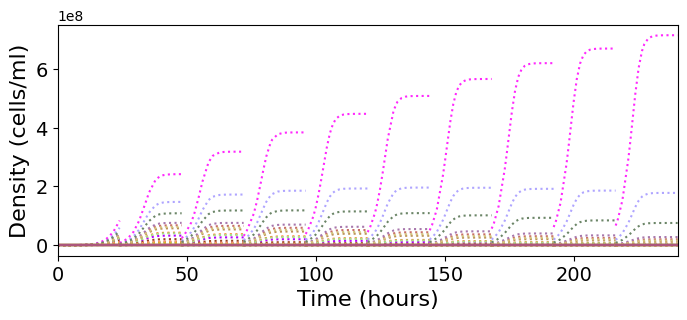

Exporting ./figures/N10/sim_densityT_N10_A0.0e-2.pdf


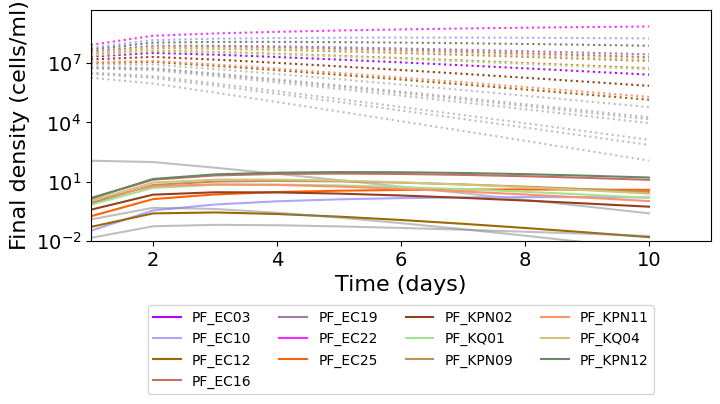

Amax=[array([2048., 2048., 2048., 2048., 2048., 2048., 2048., 2048., 2048.,
       2048.])]
istrains=[1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]
.Exporting ./figures/N10/sim_density_N10_A204800e-2.pdf


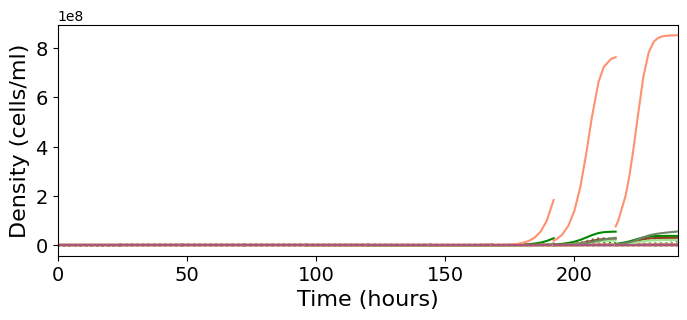

Exporting ./figures/N10/sim_densityT_N10_A204800e-2.pdf


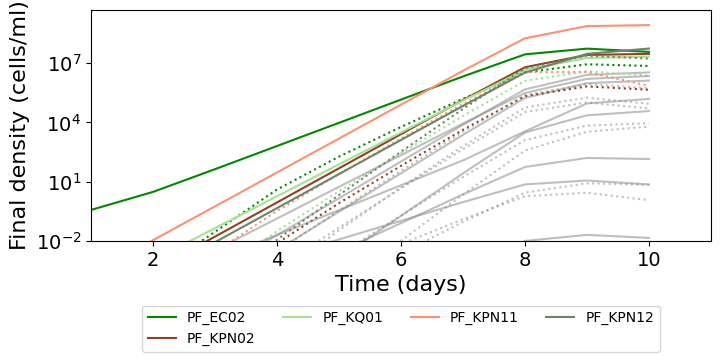

In [38]:
#istrains=[24]
istrains=strains_subset


for Amax in [0.0, 2**11]: #Amax_values:
  Es_norm=[np.ones(num_days)]
  this_Es = [Amax * e for e in Es_norm]
  print("Amax=%s"%this_Es)
  print("istrains=%s"%istrains)

  Btots, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params = simulate_environments_multistrain(model_params, istrains, this_Es, type_experiment)

  for i, E in enumerate(this_Es):
    density_path="%ssim_density_N%s_A%se-2.pdf"%(figPathN, num_days, Amax*100)
    plotTransfers(istrains, ts[i], ys[i], params[i], density_path)

    densityT_path="%ssim_densityT_N%s_A%se-2.pdf"%(figPathN, num_days, Amax*100)
    plotTransfersFinalPoint(istrains, ts[i], ys[i], params[i], densityT_path)

## Multidose / Multistrain / Multiday (Random Environment)

In [39]:


def simulate_doseResponse_multistrain(model_params, istrains, Amax_values, type_experiment='invasion', iexpe=0):

    densityT = []
    for this_Amax in Amax_values:
      E = [this_Amax * e for e in Es_norm[iexpe]]
      Btot, BpE, BpK, BfE, BfK, freqpE, freqpK, ts, ys, params_list = simulate_environment_multistrain(model_params, istrains, E, type_experiment)

        # Get final points
      final_times, final_ys = get_final_points(ts, ys)

      # Analyze simulation results
      Btot, BpE, BpK, BfE, BfK, freqpE, freqpK  = analyze_simulation(model_params, istrains, final_ys)

      densities = final_ys[-1][2:]

      densityT.append(densities)

    return np.array(densityT)


densityT=simulate_doseResponse_multistrain(model_params, istrains, Amax_values, type_experiment)

................................................................................................................................................................................................................................................

In [40]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

def plot_doseResponseSpecies_multistrain(model_params, istrains, A_values, densityT, ax):
    # Create color mapping
    num_strains = int(np.round(len(istrains)))
    species_list = model_params['specie'].unique()
    color_mapping = {species: cm.get_cmap(color, num_strains) for species, color in zip(species_list, ['Reds', 'Blues'])}


    # Plot TC strains with dotted lines
    va=np.zeros(len(A_values))
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.plot(A_values, densityT[:, i], '-', color=color)
        #ax.fill_between(A_values, va, va+densityT[:, i], color=color, alpha=0.9)

        va+=densityT[:, i]

    # Plot WT strains with solid lines
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.plot(A_values, densityT[:, i+num_strains], ':', color=color)
        #ax.fill_between(A_values, va, va+densityT[:, i+num_strains], color=color, alpha=0.5)

        va+=densityT[:, i+num_strains]


    # Plot total bacterial density as a solid line
    ax.plot(A_values, va, color='black', linewidth=2)

    ax.set_xlabel('Drug concentration', fontsize=16)
    ax.set_ylabel('Strain density (log)', fontsize=16)
    ax.set_xscale('log', base=2)
    ax.set_ylim([1e-2, 1.1*np.max(va)])
    ax.set_xlim([A_values[0], A_values[-1]])


    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    #ax.legend()

def plot_doseResponseAreaSpecies_multistrain(model_params, istrains, A_values, densityT, ax):
    # Create color mapping
    num_strains = int(np.round(len(istrains)))
    species_list = model_params['specie'].unique()
    print(species_list)
    color_mapping = {species: cm.get_cmap(color, num_strains) for species, color in zip(species_list, ['Reds', 'Blues'])}


    # Plot TC strains with dotted lines
    va=np.zeros(len(A_values))
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.plot(A_values, va+densityT[:, i], ':', color=color)
        ax.fill_between(A_values, va, va+densityT[:, i], color=color, alpha=0.9)

        va+=densityT[:, i]

    # Plot WT strains with solid lines
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.plot(A_values, va+densityT[:, i+num_strains], '-', color=color)
        ax.fill_between(A_values, va, va+densityT[:, i+num_strains], color=color, alpha=0.5, hatch='//')

        va+=densityT[:, i+num_strains]


    # Plot total bacterial density as a solid line
    ax.plot(A_values, va, color='black', linewidth=2)

    #ax.set_xlabel('Drug concentration', fontsize=16)
    ax.set_ylabel('Cumulative density', fontsize=16)
    ax.set_xscale('log', base=2)
    ax.set_ylim([1e-2, 1.2*np.max(va)])
    ax.set_xlim([A_values[0], A_values[-1]])

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)


    #ax.legend()



<ipython-input-40-6233e000e817>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_mapping = {species: cm.get_cmap(color, num_strains) for species, color in zip(species_list, ['Reds', 'Blues'])}
<ipython-input-40-6233e000e817>:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_mapping = {species: cm.get_cmap(color, num_strains) for species, color in zip(species_list, ['Reds', 'Blues'])}


['E' 'K']


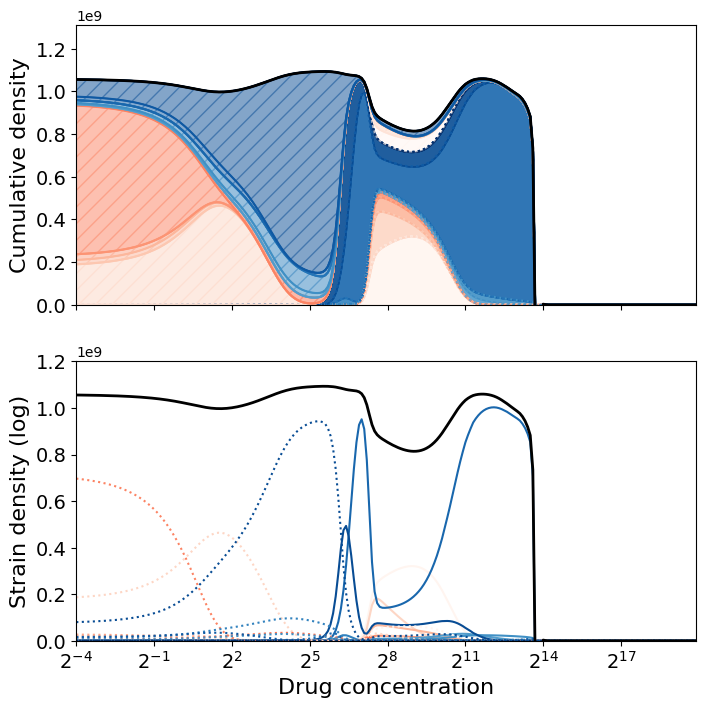

Exporting ./figures/N10/sim_doseResponse_N10.pdf


<Figure size 640x480 with 0 Axes>

In [41]:

fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

plot_doseResponseSpecies_multistrain(model_params, istrains, Amax_values, densityT, axs[1])

plot_doseResponseAreaSpecies_multistrain(model_params, istrains, Amax_values, densityT, axs[0])

#plt.tight_layout()
plt.show()



plot_path="%ssim_doseResponse_N%s.pdf"%(figPathN, num_days)
print("Exporting %s"%plot_path)
plt.savefig(plot_path)

In [42]:



def plot_doseResponse_multistrain(model_params, istrains, A_values, densityT, ax):
    num_strains = int(len(istrains))
    cmap_strains = cc.glasbey_dark[:tot_strains]

    # Plot TC strains with dotted lines
    for i in range(num_strains):
        #if np.max(densityT[:, i]) > 1e-6 or np.max(densityT[:, i+num_strains])>1e-6: # Only add a legend entry if the maximum density is >1e6
        ax.plot(A_values, densityT[:, i], '-', color=cmap_strains[istrains[i]], label=f'{strain_names[istrains[i]]}')
        #else:
        #    ax.plot(A_values, densityT[:, i], '-', color=cmap_strains[istrains[i]])

    # Plot WT strains with solid lines
    for i in range(num_strains):
        ax.plot(A_values, densityT[:, i+num_strains], ':', color=cmap_strains[istrains[i]])

    #ax.set_xlabel('Drug concentration')
    ax.set_ylabel('Strain density (log)', fontsize=16)
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=10)
    ax.set_ylim([1e-2, 1.2e9])
    ax.set_xlim([A_values[0], A_values[-1]])


    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    ax.set_xlabel('Drug concentration', fontsize=16)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4)



def plot_doseResponseAreas_multistrain(model_params, istrains, A_values, densityT, ax):
    num_strains = int(len(istrains))
    cmap_strains = cc.glasbey_dark[:tot_strains]

    # Plot TC strains with dotted lines
    va=np.zeros(len(A_values))
    for i in range(num_strains):
        #ax.plot(A_values, va+densityT[:, i], '-', color=cmap_strains[i])
        ax.fill_between(A_values, va, va+densityT[:, i], color=cmap_strains[istrains[i]], alpha=0.9)

        va+=densityT[:, i]

    # Plot WT strains with solid lines
    for i in range(num_strains):
        #ax.plot(A_values, va+densityT[:, i+num_strains], ':', color=cmap_strains[i])
        ax.fill_between(A_values, va, va+densityT[:, i+num_strains], color=cmap_strains[istrains[i]], alpha=0.5, hatch='//')

        va+=densityT[:, i+num_strains]

    ax.set_ylabel('Cumulative density', fontsize=16)
    ax.set_xscale('log', base=2)
    ax.set_ylim([1e-2, 1.2e9]) #1.1*np.max(densityT)
    ax.set_xlim([A_values[0], A_values[-1]])


    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)


    handles, labels = ax.get_legend_handles_labels()
    if labels:
        ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)



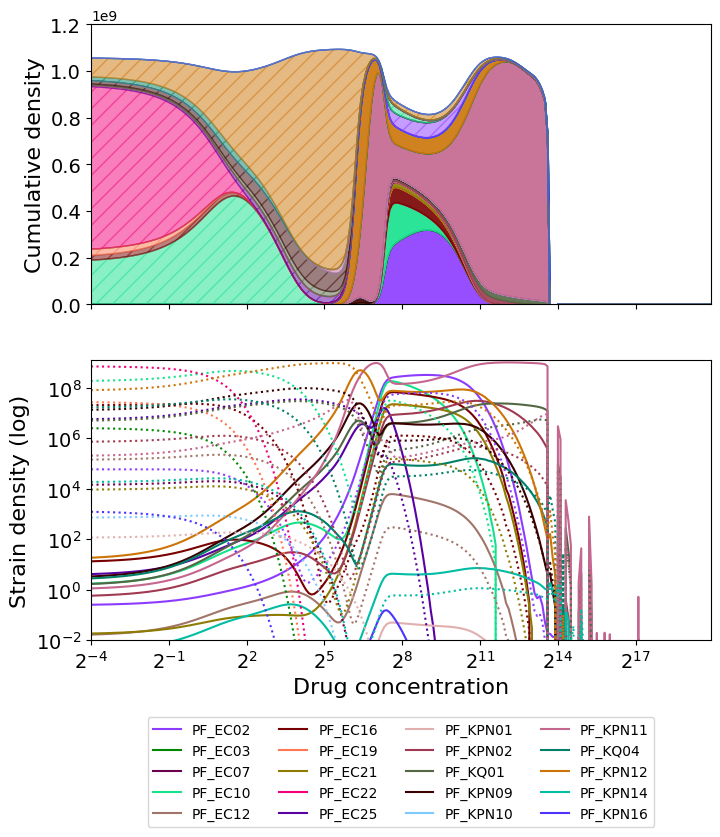

Exporting ./figures/N10/sim_doseResponse_N10.pdf


<Figure size 640x480 with 0 Axes>

In [43]:

fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)


# Plot dose-response frequencies
plot_doseResponseAreas_multistrain(model_params, istrains, Amax_values, densityT, axs[0])


# Plot dose-response area
plot_doseResponse_multistrain(model_params, istrains, Amax_values, densityT, axs[1])


plt.show()



plot_path="%ssim_doseResponse_N%s.pdf"%(figPathN, num_days)
print("Exporting %s"%plot_path)
plt.savefig(plot_path)

In [44]:
def plot_fractionPlasmidBearing_multistrain(model_params, istrains, A_values, densities, ax):

    # Create color mapping
    species_list = list(model_params['specie'].unique())
    color_mapping = {species: color for species, color in zip(species_list, ['Red', 'Blue'])}

    # Convert densities to a NumPy array
    densities = np.array(densities)

    # Calculate total density at each point
    total_density = np.sum(densities, axis=1)

    # Calculate relative abundance at each point
    relative_abundances = densities / total_density[:, np.newaxis]

    # Initialize an array for the fraction of plasmid-bearing cells
    fractions_species = np.zeros((len(A_values), len(species_list), 2))  # Added an extra dimension for WT and TC

    # Calculate the fraction of plasmid-bearing cells of each species
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        fractions_species[:, species_list.index(species), 0] += relative_abundances[:, i]  # WT
        fractions_species[:, species_list.index(species), 1] += relative_abundances[:, len(istrains) + i]  # TC

    # Plot fraction of plasmid-bearing cells with area chart
    cumulative_fraction = np.zeros(len(A_values))

    for i, species in enumerate(species_list):
        for j in range(2):  # Loop over WT and TC
            ax.fill_between(A_values, cumulative_fraction, cumulative_fraction + fractions_species[:, i, j],
                            color=color_mapping[species], alpha=0.8 if j == 0 else 0.2,
                            hatch='//' if j == 1 else None)
            cumulative_fraction += fractions_species[:, i, j]

    ax.set_xlabel('Drug concentration')
    ax.set_ylabel('Fraction of plasmid-bearing cells')
    ax.set_xscale('log', base=2)
    ax.set_ylim([0, 1])
    ax.set_xlim([A_values[0], A_values[-1]])

    #ax.legend()


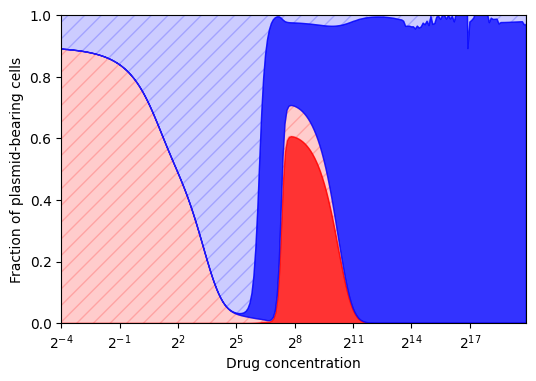

<Figure size 640x480 with 0 Axes>

In [45]:

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_fractionPlasmidBearing_multistrain(model_params, istrains, Amax_values, densityT, ax)
plt.show()


plot_path="%ssim_doseResponseFreqs_N%s.pdf"%(figPathN, num_days)
plt.savefig(plot_path)

In [1]:
def display_strain_params(model_params, istrain):
    # Display TC strain
    print(f"TC Strain {istrain+1}:")
    display_params(model_params, istrain)

    # Display WT strain
    print(f"\nWT Strain {istrain+tot_strains+1}:")
    display_params(model_params, istrain+tot_strains)

def display_params(model_params, idx):
    # Get the parameters for the specific strain
    name = model_params['strain_name'][idx]
    #color = model_params['strain_color'][idx]
    if idx<tot_strains:
      color=cmap_strains[idx]
    else:
      color=cmap_strains[idx-tot_strains]
    specie = model_params['specie'][idx]
    strain = model_params['strain'][idx]
    ptype = model_params['type'][idx]
    pcn = model_params['PCN'][idx]
    mic = model_params['MIC'][idx]
    conj = model_params['conj_rate'][idx]
    VKm = model_params['VKm'][idx]
    rho = model_params['rho'][idx]
    seg = model_params['seg_rate'][idx]
    kappa = model_params['kappa'][idx]

    # Print the parameters
    print(f"\tName: {name}")
    print(f"\tColor: {color}")
    print(f"\tSpecie: {specie}")
    print(f"\tStrain: {strain}")
    print(f"\tType: {ptype}")
    print(f"\tPCN: {pcn}")
    print(f"\tMIC: {mic}")
    print(f"\tConjugation Rate: {conj}")
    print(f"\tVKm: {VKm}")
    print(f"\tRho: {rho}")
    print(f"\tSegregation Rate: {seg}")
    print(f"\tKappa: {kappa}")


#istrain=43
#display_strain_params(model_params, istrain)
